Sound source localization with a microphones array : beamforming approaches

---

Made by : Zahra BENSLIMANE 

Lab instructor: Sylvain Argentieri.


You have characterized and analyzed the sound propagation in the previous practical. We will now
exploit theses properties to infer one sound source position w.r.t.\ a linear microphone array made
of $N=8$ omnidirectional MEMS microphones. The system you will be using is the same as before;
thus, most of the code you already wrote to acquire signals, plot them, etc.\ will remain the same.

In all the following, the acquisition system will work with a sampling frequency $F_s = 20$kHz, and with a buffer of size $\texttt{BLK} = 2048$.

In [1]:
# All required import
import matplotlib.pyplot as plt
import ipywidgets as widgets
import numpy as np
from client import array
import time
%matplotlib notebook

<div class="alert alert-block alert-danger"> Please run the following cell and select the file "recordings/1kh_a_droite_45.h5" </div>

In [2]:
#antenne=array('server') # When performing real-time acquisition
antenne=array('play')   # When playing recorded files

In [154]:
# Load acquisition and array parameters from the antenne variable, after launching acquisition or play
Fs = antenne.fs
BLK = antenne.blocksize
N = antenne.mems_nb
d = antenne.interspace

### 1) To begin, start the acquisition of the audio system, and capture one audio buffer. Plot the resulting signals as a function of time.

In [155]:
# Read an audio buffer
m = antenne.read()

def plot_signal (signal, microphones, xlim):
    plt.figure(figsize = (10,4))
    for microphoneNumber in microphones:
        microphone_signal = signal[microphoneNumber,:]
        t =  (1/Fs)*np.arange(len(microphone_signal))
        plt.plot(t,microphone_signal, label = "Mic{}".format(microphoneNumber))
    plt.title('Display the waveforms recorded by the microphones ')
    plt.xlabel("Time(s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.xlim(xlim)

In [156]:
def plot_fft(signal, microphone, f = np.arange(0, Fs, Fs/BLK), plot_absFFT_only = False):
    # Compute fft
    s = signal[microphone,:]
    fft = np.fft.fft(s)
    
    if plot_absFFT_only == True : nbGraphe = 1
    else: nbGraphe = 2
            
    # plot the absolute value of fft and its spectrum
    #plt.figure(figsize = (10,4))
    plt.subplot(1,nbGraphe,1)
    plt.plot(f, np.abs(fft), label = "M{}".format(microphone))
    plt.title("Amplitude du spectre du signal M{}".format(microphone))
    plt.xlabel("Frequency(Hz)")
    plt.ylabel("$|TFD(M{})|$".format(microphone))
    plt.xlim(0, 1500)
    plt.legend()
    plt.grid(True)  

    if  plot_absFFT_only == False:
        plt.subplot(1,nbGraphe,2)
        plt.phase_spectrum(s, Fs=Fs, color='C1')
        plt.title("Phase du Spectre du signal M{}".format(microphone))
        plt.xlabel("Frequency(Hz)")
        plt.grid(True)

<IPython.core.display.Javascript object>


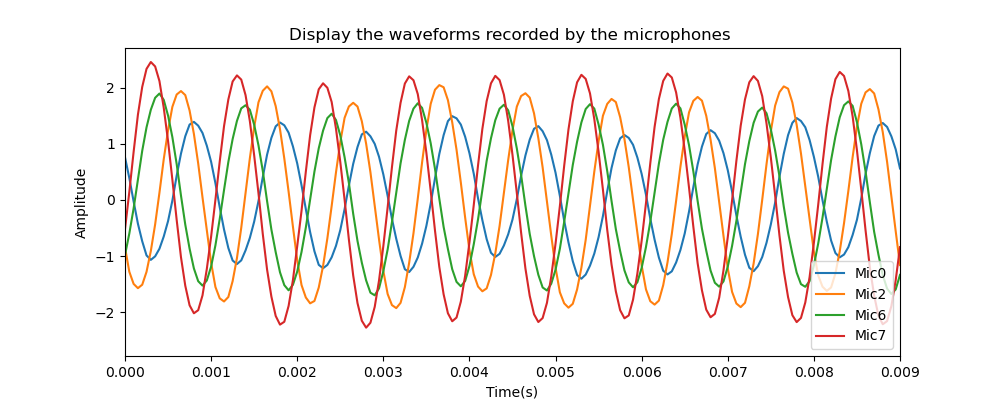

<IPython.core.display.Javascript object>


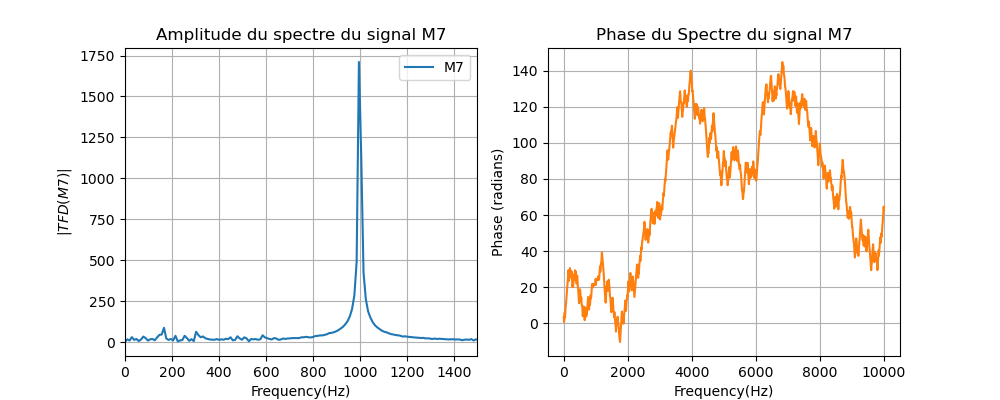

In [157]:
plot_signal(m,microphones = [0,2,6,7], xlim=(0,0.009))
plt.figure(figsize = (10,4))
plot_fft(m, microphone = 7)

<div class="alert alert-block alert-success"> 
    
    
Notes : 
    
- A pure sine wave with a frequency of 1000Hz  is sent from a sound souce placed at more then 40 centimeters of the microphone array with an angle of about $\pi/4$  
    
- The microphones outputs are saved in a file called "1KH.hz" and then loaded to un matrix buffer with the size of [8*2048] 
    
- Avec comme hypothèse du fait que la source champs lointain:
    
- We assume  a far feild model : The sound wave travels perpendicular to the traveling direction at an angle $\Theta$ to the broadside direction of the linear array
    
    - Note that all the signals are shifted in time by a certain value which corresponds to the time taken by the sound wave to reach each of the microphones :  The time shift is dependent on the the position of whitch the sine way has been sent.
    
    - Although the amplitude varies, contrary to what was expected in theory, and that is due to the fact that the audio source was closer to some microphones than others.
   
    
</div> 

## 2.1/ Coding the beamformer filters and analyzing their properties

**These first questions have to be prepared before the practical session**

### 2) Write the position $z_n$ as a function of $n$ and interspace $d$. As a convention, the first microphone number is selected as $0$.

One can write :
$$z_n = (n - \frac{N+1}{2}) * d$$

$$$$

### 3) Propose a function $\texttt{beam_filter}$ returning the filter frequency response for one microphone number $\texttt{mic_nb}$. 


will use filters with a frequency response $Wn(f)$ given by

$ \DeclareMathOperator{\e}{e}$
$$ W_n(f) = TF[\omega_n(t)] =  \e^{2*j \pi \frac{f}{c} z_n \cos\theta_0}  $$ 

where $z_n$ is the position of the nth microphone along its axis,given above and $\theta_0$ is the angular direction in
which the beamformer is focalized

In [158]:
def beam_filter_etu(array, freq_vector, theta0=0, mic_nb: int = 0):
    """Compute the filter frequency response of a DSB beamformer for one microphone

    Args:
        array (array_server obj): array structure controlling the acquisition system.
        freq_vector (np.array): frequency vector. 
        theta0 (int, optional): focusing angular direction (in degrees). Defaults to 0.
        mic_id (int, optional): microphone id. Defaults to 0.

    Returns:
        np.array: the filter frequency response. Shape is (len(freq_vector),).
    """

    N = antenne.mems_nb
    d = antenne.interspace
    # Microphone position x
    z = (mic_nb - N -1)/2 * d
    # Filter's frequency response
    return np.exp (-2j *np.pi *freq_vector/340 * z *np.cos(theta0 *np.pi /180 ))

### 4) Plot the two frequency responses obtained for two filters associated to two different microphone outputs when $\theta_0=0^\circ$ and for frequencies between $0$ and $5$kHz. Explain the effect of these filters on the signals.

<IPython.core.display.Javascript object>


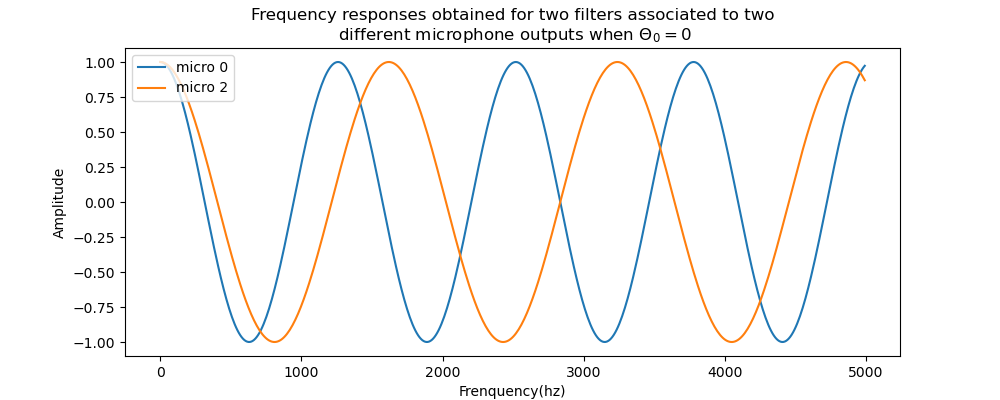

In [159]:
# TO BE COMPLETED
f = np.arange(0, 5000, Fs/BLK)
plt.figure(figsize = (10,4))
microphones = [0,2]
for i in microphones:
    frequency_response = beam_filter_etu(antenne, f, 0, i)
    plt.plot(f, frequency_response, label = "micro {}".format(i))
plt.title("Frequency responses obtained for two filters associated to two\n different microphone outputs when $\Theta_0 = 0 $")
plt.xlabel("Frenquency(hz)")
plt.legend(loc='upper left')
plt.ylabel("Amplitude")
plt.show()


### 5) Compare again the filters obtained when $\theta_0 = 90^\circ$. Explain the differences.

<IPython.core.display.Javascript object>


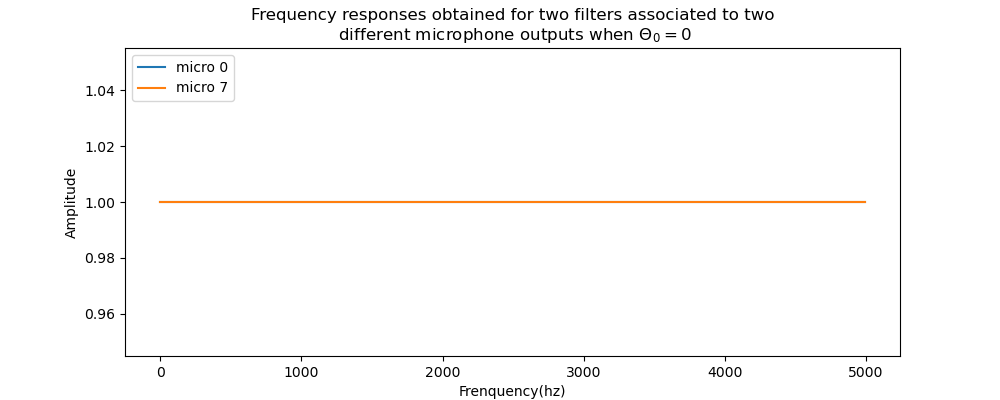

In [160]:
f = np.arange(0, 5000, Fs/BLK)
plt.figure(figsize = (10,4))
microphones = [0,7]
for i in microphones:
    frequency_response = beam_filter_etu(antenne, f, 90, i)
    plt.plot(f, frequency_response, label = "micro {}".format(i))
plt.title("Frequency responses obtained for two filters associated to two\n different microphone outputs when $\Theta_0 = 0 $")
plt.xlabel("Frenquency(hz)")
plt.legend(loc='upper left')
plt.ylabel("Amplitude")
plt.show()

<div class="alert alert-block alert-success"> 
    
$ \DeclareMathOperator{\e}{e}$
$$ W_n(f) =  \e^{2*j \pi \frac{f}{c} z_n \cos\theta_0}  = 1,  when :  \theta_0 = 0  $$ 

The graph above shows that each filter apllied to the microphone array would have no effect when acquitioning the sound waves at theta = 0.
    
    
</div>

<div class="alert alert-block alert-success"> 
    
The goal with the usings this filter on the outputs on the microphone signals is to re-shift the signals again to compensate for delays related to wave propagation.
    
- All the microphones are recalibrated for this particular virtual transmission position.       
    
- If we compensate the signals very well we will get exactly the same signal at the output of all microphones, so theoretically 8 times the signal, but since we don't have the same amplitude for all microphones, we will search for the maximum signal power only.
    
- If the compensate with a delay corresponding to a an angle $\theta$ which does not correspond to the sound source emmition angle, we end up with destructive interferences, which is translated with a low power value.  
    
    
</div>

## 2.2/ Using the filters : coding of the beamforming

<div class="alert alert-block alert-info"> <b> The beamforming algorithm is the following :</b> 

- (a) acquire an audio frame
    
- (b) compute the corresponding FFT
    
- (c) analyze the FFT to define which frequency(ies) you would like to localize
    
- (d) restrict the FFT to the frequencies of interest
    
- (e) for one given $\theta_0$ , for the frequencies selected before, and for each microphone :
  
    — compute the corresponding filters frequency responses with the beam_filter func-tion
    
    — apply these filters to the microphone outputs
    
    
- (f) compute the beamformer output associated to the angular polarization $\theta_0$
    
- (g) repeat all these last steps for each $\theta_0$  you want to test
    
- (h) finally, decide of the angular position of the source by detecting for which $\theta_0$ the beam-
former output is maximum.    
    
</div>


### 6) Step (a) and (b) : After acquiring an audio buffer, compute its FFT in an array $\texttt{M_fft}$. Plot the result of this analysis as a function of the frequency when emitting a pure sine tone with a frequency $F_0 = 1$kHz.

<IPython.core.display.Javascript object>


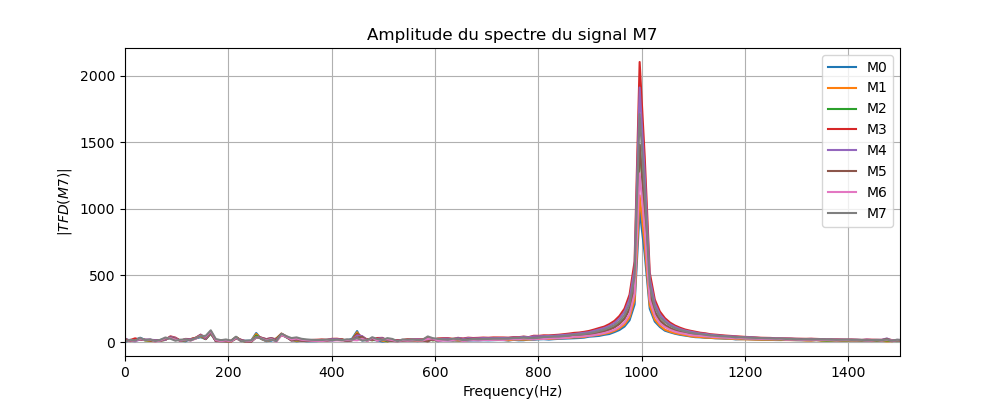

In [161]:
# Compute FFT of the acquired audio buffer
M_fft = np.fft.fft(m)
f = np.arange(0, Fs, Fs/BLK)

plt.figure(figsize = (10,4))
for indx in range(8):
    plot_fft(m, microphone = indx, f = f, plot_absFFT_only = True)
    

<div class="alert alert-block alert-success"> 

We obviously notice that the audio signals being recorded do have the intended frequency of 1Khz. But we can also see some noise which apprears in the low frequencies due to the noisy environement of recording.
    
</div>

### 7) Step (c) and (d) : Among all the frequencies you obtained from the FFT, select the one corresponding to the source frequency. Give its exact value and index $k_0$ in the frequency array.

In [162]:
# Compute K0 as the list index of the maximum value of abs(fft)
F0 = 1000
M7 = M_fft[7,:]
k0 = np.argmax(np.abs(M7[0:BLK//2]))
k02 = (np.abs(f - F0))

k03 = np.min(np.argmax(np.abs(M_fft[:,0:BLK//2]), axis = 1 ))

print("k0 = ", k0)
print("La fréquence à k0 : f[k0] =", f[k0]) 

k0 =  102
La fréquence à k0 : f[k0] = 996.09375


<div class="alert alert-block alert-success"> 

We determined the value of the index k0 which corresponds to the microphones FFT responses seen in the graph above at 1 Khz    
</div>

####  collect the corresponding FFT values of each microphone outputs in one vector  𝙼  of length  𝑁

In [163]:
M = []
for i in range(8):
    M.append(M_fft[i][k0]) 
print("M = ")
for complexValue in M:
     print(complexValue)

M = 
(-743.5152936733498+650.9537059002303j)
(-1076.0690835280068+234.70109759046284j)
(-1409.11783548606-449.55722837168685j)
(-1747.7333713035875-1168.031678963524j)
(-1377.198329359797-1324.233744450204j)
(-632.0211564890379-1340.3796139061674j)
(450.62989681050055-1182.728795333916j)
(1336.4267639781337-1067.6127339080617j)


<div class="alert alert-block alert-success"> 
    
Since our source signal is a mono-frequency signal, We only kept the values of the FFT that correspond to our frequency on interest for the rest of the analysis. So we end up with 8 complex values.
    
    
</div>

### 8) Step (e) : In a loop among all microphones, compute each filters for the position $\theta_0$ and for the frequency value you obtained in the previous step. Apply then these filters to the array $\texttt{M}$ defined before.

In [164]:
# TO BE COMPLETED
filter_outputs_at_theta0 = []
for i in range(8):
    val = M[i] *  beam_filter_etu(antenne, f[k0], theta0 = 0, mic_nb = i)
    filter_outputs_at_theta0.append(val) 
    

print("filter_outputs_at_theta0 = ")
for complexValue in filter_outputs_at_theta0:
    print(complexValue)

filter_outputs_at_theta0 = 
(439.96040159687027+884.8675404703981j)
(536.961313740368+961.6037776970254j)
(757.8276537316151+1270.2015679040028j)
(1522.3137136350053+1449.6312970922475j)
(1770.4477809537104+718.1816645167901j)
(1453.097564277576+290.8190508126377j)
(1139.704781574531+550.4432014909524j)
(1554.4902525306738+713.7180815047591j)


### 9) Step (f): Combine then the filters outputs to form the beamformer output $Y_{\theta_0}[k_0]$. *$Y_{\theta_0}[k_0]$ is obviously a complex value which corresponds to the frequency contribution of the source to the $k_0^{\text{th}}$ frequency component of the beamformer output when focalized in the direction $\theta_0$.* Compute then the corresponding power $P(\theta_0)$ at $k_0$ of the beamformer output.

In [165]:
# TO BE COMPLETED
Y_theta0 = np.sum(filter_outputs_at_theta0)
print("beamformer output : \nY_theta0 = ", Y_theta0)

P_theta0 = np.abs(Y_theta0)**2
print("P_theta0 = ", P_theta0)

beamformer output : 
Y_theta0 =  (9174.80346204035+6839.466181488813j)
P_theta0 =  130955316.2147968


### 10) For a direction $\theta_0$ of your choice, compute $P(\theta_0)$ for (i) a source emitting from a direction close to $\theta_0$, or (ii) far from it. Compare the two values.

In [166]:
# For theta0 = 120°

filter_outputs_theta120 = []
for i in range(8):
    val = M[i] *  beam_filter_etu(antenne, f[k0], 120 , mic_nb = i)
    filter_outputs_theta120.append(val) 
    
Y_theta120 = np.sum(filter_outputs_theta120)
print("Y_theta90 = ", Y_theta120)

P_theta120 = np.abs(Y_theta120)**2
print("P_theta00 = ", P_theta120)


Y_theta90 =  (-2150.562238990782+2303.4185365497124j)
P_theta00 =  9930654.898293862


<div class="alert alert-block alert-success"> 

With our sinus emmited from an angle of about $ \frac{\pi}{4}$, we indeed got a higher power with a filter delaying the microphone outputs with an angle of $\theta_0 = 0°$ than with a $\theta_0 = 120°$ since our source is closer to 0°
     
--- 
    
The determin the sound source emission angle, we test several different theta0 and plot the squared modulus of the sum of the 8 filtered microphone outputs, which can correspond to a power value.
    
We then expect that the power of voice formation is  greater for the value of theta0 $\theta_0$ that produces a delay at the output of the filters corresponding to those supported by the propagation of the sound wave.
    
    
</div>

### 11) Step (g) : Repeat now the previous code in a loop for $\theta_0$ values ranging from 0 to 180° .You should then obtain an array $\texttt{P}$ where each value corresponds to the power of the beamformer output at $F_0$ for each angular polarization. Plot the array $\texttt{P}$ as a function of the angle $\theta_0$.

<IPython.core.display.Javascript object>


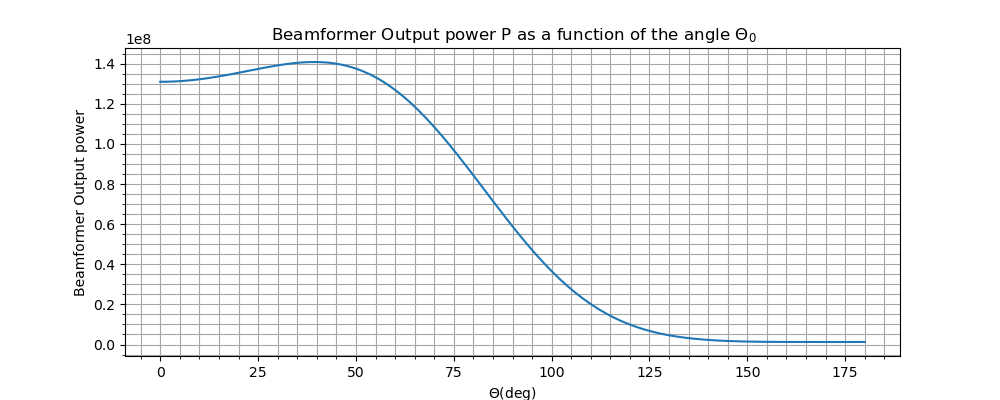

In [167]:
thetaTab = np.arange(0, 181, 1)
power = []
for theta in thetaTab:
    filter_outputs = []
    for i in range(8):
        val = M[i] *  beam_filter_etu(antenne, f[k0], theta , mic_nb = i)
        filter_outputs.append(val) 
    Y = np.sum(filter_outputs)
    P = np.abs(Y)**2
    power.append(P)
    
plt.figure(figsize = (10,4))
plt.plot(thetaTab,power)
plt.title(" Beamformer Output power P as a function of the angle $\Theta_0$ ")
plt.xlabel("$\Theta$(deg)")
plt.ylabel("Beamformer Output power")
plt.grid(visible=True, which='both', color='0.65', linestyle='-')
plt.minorticks_on()

### 12) Step (h) : Find the $\theta_0$ value corresponding to position of the maximum in $\texttt{P}$ and compare it with the actual (but approximate) position of the sound source.

In [168]:
print("The Angle corresponding to the highest computed Power :", np.argmax(power))

The Angle corresponding to the highest computed Power : 39


<div class="alert alert-block alert-success"> 
    
As wished, we estimated an angle of 39°, which roughly correspond to the real angle of emission     
    
</div>

## Let's Wrap Up The Algorithm 

In [132]:
 def myBeamformer(buffer, theta , F0 , Fs):
    """ Compute the energy map from a Delay -And -Sum beamforming
    Args :
    buffer (np. array ): audio buffer , of size N x BLK_SIZE
    theta (np. array ): array of angular value in degrees listing the polarization angle of the beamformer
    F0 ( float ): source frequency to localize
    Fs ( float ): sampling frequency
    """
    N, BLK = np.shape(buffer)
    M_fft = np.fft.fft(buffer)
    f = np.arange(0, Fs, Fs/BLK)
    
    #k0 = np.min(np.argmax(np.abs(M_fft[:,0:BLK//2]), axis = 1 ))
    k0 = (np.argmin(np.abs(f - F0)))
    
    M = M_fft[:, k0]
    power = []    
    for myTheta in theta:
        W = []
        for i in range(N):
            W.append(beam_filter_etu(antenne, f[k0], theta0 = myTheta, mic_nb= i))
         
        # Beamformer Ouput
        Y = M*W
        # Compute Power coresponding to theta
        P = np.abs(np.sum(Y))**2
        power.append(P)
        
    return power

## 2.3/ Analyzing the beamformer performances

From now on, you can use your own code written in Section 2.2, or use the provided beamformer function which exactly reproduces the beamformer algorithm. You might then add $\texttt{from beamformer_etu import beamformer}$ in your Notebook before being able to use the beamformer function.

In [133]:
from beamformer_etu import beamformer

#### Check if we got the same thin

### 13) Plot the energy maps you obtain when using source frequencies $F_0 = 400$Hz, $F_0 = 1$kHz, $F_0 = 2$kHz and $F_0 = 4$kHz emitting from a fixed arbitrary position. Comment and explain carefully the differences between these curves

In [134]:
# Load the previously saved audio buffers
m_400hz =  np.load("saved_audio_buffers/400Hz.npy")
m_1000hz = np.load("saved_audio_buffers/1000Hz.npy")
m_2000hz = np.load("saved_audio_buffers/2000Hz.npy")
m_4000hz = np.load("saved_audio_buffers/4000Hz.npy")

In [135]:
# Compute their power maps 
theta = np.arange(0,180, 1)
P400hz  = myBeamformer(m_400hz, theta, 400, Fs)
P1000hz = myBeamformer(m_1000hz, theta , 1000, Fs)
P2000hz = myBeamformer(m_2000hz, theta , 2000, Fs)
P4000hz = myBeamformer(m_4000hz, theta , 4000, Fs)

P = [P400hz, P1000hz,P2000hz,P4000hz]

<IPython.core.display.Javascript object>


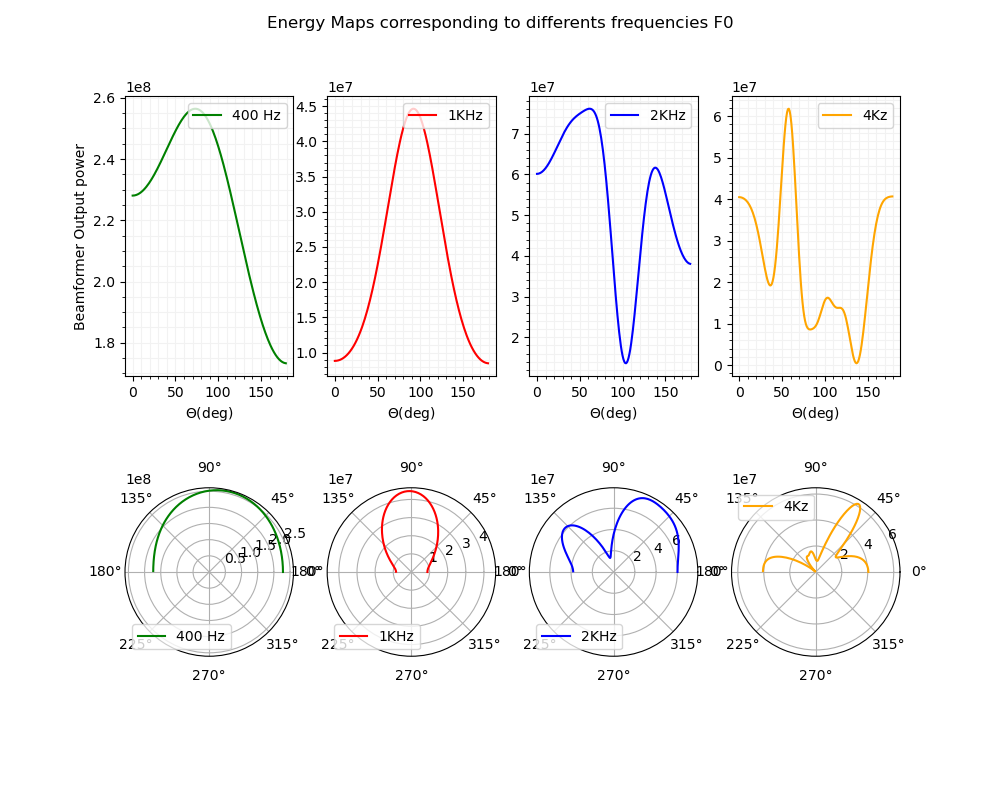

In [136]:
plt.figure(figsize=(10,8))
plt.suptitle("Energy Maps corresponding to differents frequencies F0")
labels = ['400 Hz','1KHz', '2KHz', '4Kz']
colors = ['green', 'red', 'blue', 'orange'] 

for i in range(len(P)):
    plt.subplot(2,4,i+1)
    plt.plot(theta, P[i][0:180], color=colors[i], label = labels[i])
    plt.legend(loc='upper right')
    plt.xlabel("$\Theta$(deg)")
    if i == 0 : plt.ylabel("Beamformer Output power")
    plt.grid(visible=True, which='both', color='0.95', linestyle='-')
    plt.minorticks_on()
    
    
plt.suptitle("Energy Maps corresponding to differents frequencies F0")
for i in range(len(P)):
    plt.subplot(2,4,5+i, polar = True)
    plt.polar(theta*np.pi/180, P[i], color=colors[i], label = labels[i])
    plt.legend()

**Note that all parameters are kept constant in this experiment, were we only varies the frequency of the emmited signal.**

<div class="alert alert-block alert-success"> 
    
#### The influence of the frequency of the emmited signal 

The spatial selectivity is higher for high frequencies.


--- 

In the last figure (orange diagram), corresponding to the Energy maps of a frequency equal to 4Kh, we can observe the appearance of an interesting phenomenon, called spatial aliasing.

We are familiar the sampling aliasing that appears when we igitize an analog signal in time domain, that does not permit us to correctly reconstruct the original signal an analog signal from a digital one. 

The spatial aliasing, in the other hand, when occurs, creates direction finding ambiguity.

To avoid this, the spacing between elements in a microphone array needs to conform to this spatial Shannon criterion: 


$$ d < d_{max} = \frac{\lambda_{min}}{2}  = \frac{c}{2*f_{max}} $$


With $\lambda$ the wavelength of the maximum frequency of the signal and c the speed of sound.

In our case : 
- c = 340m/s
- Fmax = 4000Hz
- d = 0.06 m

But,

$$ d <  \frac{340}{2*4000}  = 0.0425 $$


So for f = 4000Khz, we did not respect the sampling theorem.

The maximum supported frequency is equal to : $f_{max} = \frac{c}{2*d} = \frac{340}{2*0.06} = 2833.33 Hz$
    
    
</div>
    

### 14) For a frequency $F_0 = 1$kHz and a source moving aroud the array, plot the estimated position as a function of time. Comment the effectiveness of the approach and its limits.

<div class="alert alert-block alert-success"> 
    
For this next experiment, we recorded an audio doing a small arc going from about 120° to almost 40°
    
</div>
    

<IPython.core.display.Javascript object>


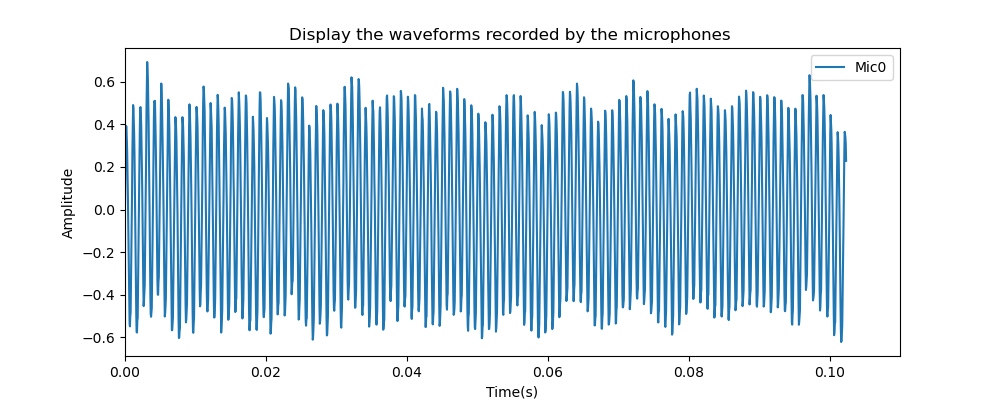

<IPython.core.display.Javascript object>


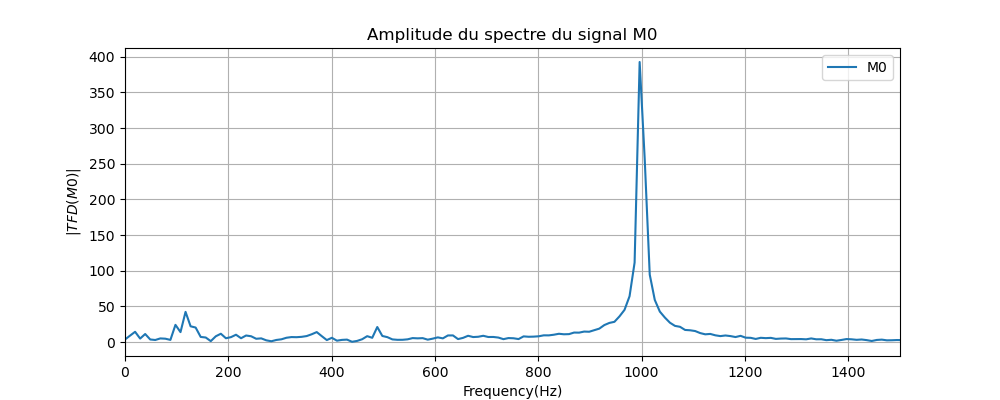

In [137]:
aroundTheArray = np.load("saved_audio_buffers/AroundTheWorld.npy")
plot_signal (aroundTheArray, microphones = [0], xlim = (0,0.11))
plt.figure(figsize = (10,4))
plot_fft(aroundTheArray, microphone = 0, f = np.arange(0, Fs, Fs/BLK), plot_absFFT_only = True)

<div class="alert alert-block alert-danger"> 
    
    
### Note

Now that we checked that the frequency of the signal is correct. The  buffer only takes about 0.1 seconds of the full recording, so we have to convert the .h5 file to an np array that we could store and use in the following experiment.
    
In the next cell, a code from : https://stackoverflow.com/questions/61133916/is-there-in-python-a-single-function-that-shows-the-full-structure-of-a-hdf5-fi
    
That helps us see how the recordings were saved in the .h5 file.

</div>

In [153]:
import h5py
# From :  https://stackoverflow.com/questions/61133916/is-there-in-python-a-single-function-that-shows-the-full-structure-of-a-hdf5-fi
def h5_tree(val, pre=''):
    items = len(val)
    for key, val in val.items():
        items -= 1
        if items == 0:
            # the last item
            if type(val) == h5py._hl.group.Group:
                print(pre + '└── ' + key)
                h5_tree(val, pre+'    ')
            else:
                print(pre + '└── ' + key + ' (%d)' % len(val))
        else:
            if type(val) == h5py._hl.group.Group:
                print(pre + '├── ' + key)
                h5_tree(val, pre+'│   ')
            else:
                print(pre + '├── ' + key + ' (%d)' % len(val))

with h5py.File('recordings/aroudTheWorld.h5', 'r') as hf:
    print(hf)
    h5_tree(hf)

<HDF5 file "aroudTheWorld.h5" (mode r)>
└── muh5
    ├── 0
    │   └── sig (8)
    ├── 1
    │   └── sig (8)
    └── 2
        └── sig (8)


**We store the recorded audio of the 8 microphones in a matrix**

In [169]:
f = h5py.File('recordings/1000 Turning.h5')
indexes = list(map(int, f['muh5'].keys())) 

print(indexes)

aroundTheArray = f['muh5']['0']['sig'][()]

print(aroundTheArray.shape)
for i in indexes[0:] :
    if i != 0:
        aroundTheArray = np.concatenate(( aroundTheArray , f['muh5'][str(i)]['sig'][()]  ), axis = 1)
 
print("aroundTheArray is of shape of : ",aroundTheArray.shape)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
(8, 20000)
aroundTheArray is of shape of :  (8, 200000)


<IPython.core.display.Javascript object>


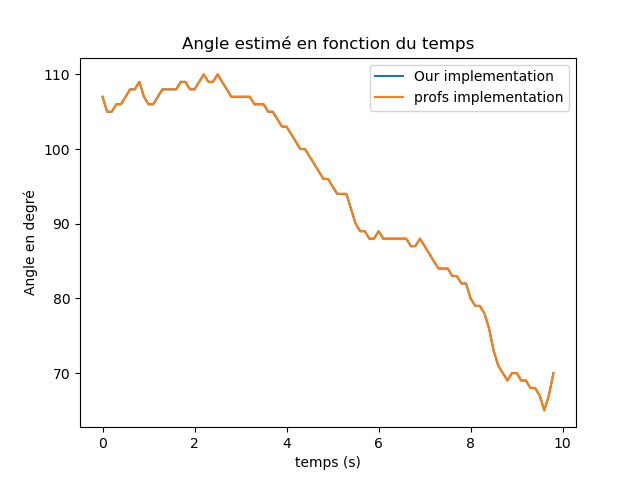

In [171]:
step  = 2000
estimatedAngle_etu = []
estimatedAngle_prof = []

theta  = np.arange(0,181, 1)
F0 = 1000

for i in range(0, aroundTheArray.shape[1] - step, step):
    buffer = aroundTheArray[:,i:i+step]
    P_etu  =  myBeamformer(buffer, theta, F0, Fs)
    estimatedAngle_etu.append(np.argmax(P_etu))
    
    P_prof = beamformer(buffer, theta, F0, Fs)
    estimatedAngle_prof.append(np.argmax(P_prof))

    
t = range(0, aroundTheArray.shape[1] - step, step)/Fs   
    
plt.figure()
plt.plot(t, estimatedAngle_etu, label = 'Our implementation')
plt.plot(t, estimatedAngle_prof, label = 'profs implementation')
plt.xlabel("temps (s)")
plt.ylabel("Angle en degré")
plt.title("Angle estimé en fonction du temps")   
plt.legend()

Some comments

<div class="alert alert-block alert-success"> 
    
We can see say that the algorithm works fine, if we take into consideration.


### Conclusion :
    
in this lab we were able to code the one of the most basic beamforming algorithm, known as the delay and sum beamformer DAS
    
    
</div>
    